In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn import model_selection
from sklearn.metrics import accuracy_score
import xgboost as xgb
from copy import deepcopy
from tqdm import tqdm
import time
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

In [3]:
train_home_team_statistics_df = pd.read_csv('data/Train_Data/train_home_team_statistics_df.csv', index_col=0)
train_away_team_statistics_df = pd.read_csv('data/Train_Data/train_away_team_statistics_df.csv', index_col=0)


train_scores = pd.read_csv('data/Y_train_1rknArQ.csv', index_col=0)

train_home = train_home_team_statistics_df.iloc[:,2:]
train_away = train_away_team_statistics_df.iloc[:,2:]

train_home.columns = 'HOME_' + train_home.columns
train_away.columns = 'AWAY_' + train_away.columns

train_data =  pd.concat([train_home,train_away],join='inner',axis=1)
train_scores = train_scores.loc[train_data.index]

train_data = train_data.replace({np.inf:np.nan,-np.inf:np.nan})

In [4]:
train_scores

,HOME_WINS,DRAW,AWAY_WINS
ID,,,
0,0,0,1
1,0,1,0
2,0,0,1
3,1,0,0
4,0,1,0
...,...,...,...
12298,0,0,1
12299,0,0,1
12300,0,0,1


In [5]:
train_scores_indices = train_scores.idxmax(axis=1).map({'HOME_WINS': 0, 'DRAW': 1, 'AWAY_WINS': 2})

In [6]:
train_data = train_data.filter(regex='sum$')

We try to model if AWAY wins

In [7]:
# train_new_y = train_scores['AWAY_WINS']

In [8]:
# X_train, X_test, y_train, y_test = model_selection.train_test_split(train_data, train_new_y, train_size=0.8, random_state=42)
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(train_data, train_scores_indices, train_size=0.8, random_state=42)

In [9]:
X_train

,HOME_TEAM_SHOTS_TOTAL_season_sum,HOME_TEAM_SHOTS_INSIDEBOX_season_sum,HOME_TEAM_SHOTS_OFF_TARGET_season_sum,HOME_TEAM_SHOTS_ON_TARGET_season_sum,HOME_TEAM_SHOTS_OUTSIDEBOX_season_sum,HOME_TEAM_PASSES_season_sum,HOME_TEAM_SUCCESSFUL_PASSES_season_sum,HOME_TEAM_SAVES_season_sum,HOME_TEAM_CORNERS_season_sum,HOME_TEAM_FOULS_season_sum,...,AWAY_TEAM_ATTACKS_5_last_match_sum,AWAY_TEAM_PENALTIES_5_last_match_sum,AWAY_TEAM_SUBSTITUTIONS_5_last_match_sum,AWAY_TEAM_BALL_SAFE_5_last_match_sum,AWAY_TEAM_DANGEROUS_ATTACKS_5_last_match_sum,AWAY_TEAM_INJURIES_5_last_match_sum,AWAY_TEAM_GOALS_5_last_match_sum,AWAY_TEAM_GAME_WON_5_last_match_sum,AWAY_TEAM_GAME_DRAW_5_last_match_sum,AWAY_TEAM_GAME_LOST_5_last_match_sum
ID,,,,,,,,,,,,,,,,,,,,,
9107,3.0,3.0,5.0,1.0,3.0,3.0,2.0,6.0,5.0,9.0,...,5.0,0.0,0.0,6.0,4.0,3.0,4.0,6.0,5.0,2.0
8231,1.0,1.0,0.0,2.0,0.0,4.0,2.0,7.0,0.0,7.0,...,2.0,0.0,1.0,2.0,2.0,6.0,3.0,6.0,2.0,2.0
5367,5.0,6.0,4.0,6.0,4.0,7.0,6.0,1.0,6.0,5.0,...,0.0,5.0,6.0,NaN,0.0,NaN,6.0,7.0,0.0,4.0
3264,6.0,6.0,4.0,5.0,6.0,5.0,4.0,9.0,8.0,0.0,...,0.0,0.0,10.0,7.0,3.0,4.0,0.0,4.0,10.0,0.0
9590,3.0,3.0,5.0,3.0,3.0,2.0,1.0,10.0,4.0,6.0,...,4.0,3.0,1.0,4.0,6.0,1.0,8.0,6.0,3.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11964,5.0,5.0,6.0,5.0,6.0,1.0,0.0,7.0,0.0,10.0,...,10.0,10.0,0.0,6.0,7.0,2.0,2.0,5.0,0.0,6.0
5191,10.0,4.0,10.0,5.0,10.0,3.0,3.0,1.0,7.0,3.0,...,9.0,5.0,10.0,8.0,8.0,1.0,5.0,6.0,0.0,4.0
5390,5.0,5.0,5.0,4.0,8.0,4.0,4.0,1.0,5.0,7.0,...,3.0,0.0,10.0,4.0,2.0,6.0,3.0,8.0,3.0,0.0


Epoch [1/30], Loss: 1.0897, Accuracy: 44.62%
Epoch [2/30], Loss: 1.0694, Accuracy: 45.96%
Epoch [3/30], Loss: 1.0596, Accuracy: 46.40%
Epoch [4/30], Loss: 1.0514, Accuracy: 46.89%
Epoch [5/30], Loss: 1.0467, Accuracy: 47.42%
Epoch [6/30], Loss: 1.0437, Accuracy: 47.58%
Epoch [7/30], Loss: 1.0420, Accuracy: 47.70%
Epoch [8/30], Loss: 1.0399, Accuracy: 47.83%
Epoch [9/30], Loss: 1.0387, Accuracy: 48.23%
Epoch [10/30], Loss: 1.0366, Accuracy: 49.00%
Epoch [11/30], Loss: 1.0365, Accuracy: 48.48%
Epoch [12/30], Loss: 1.0349, Accuracy: 48.68%
Epoch [13/30], Loss: 1.0344, Accuracy: 48.56%
Epoch [14/30], Loss: 1.0341, Accuracy: 48.64%
Epoch [15/30], Loss: 1.0331, Accuracy: 48.84%
Epoch [16/30], Loss: 1.0334, Accuracy: 48.72%
Epoch [17/30], Loss: 1.0330, Accuracy: 48.60%
Epoch [18/30], Loss: 1.0319, Accuracy: 48.64%
Epoch [19/30], Loss: 1.0316, Accuracy: 48.72%
Epoch [20/30], Loss: 1.0310, Accuracy: 49.09%
Epoch [21/30], Loss: 1.0309, Accuracy: 48.96%
Epoch [22/30], Loss: 1.0310, Accuracy: 49.1

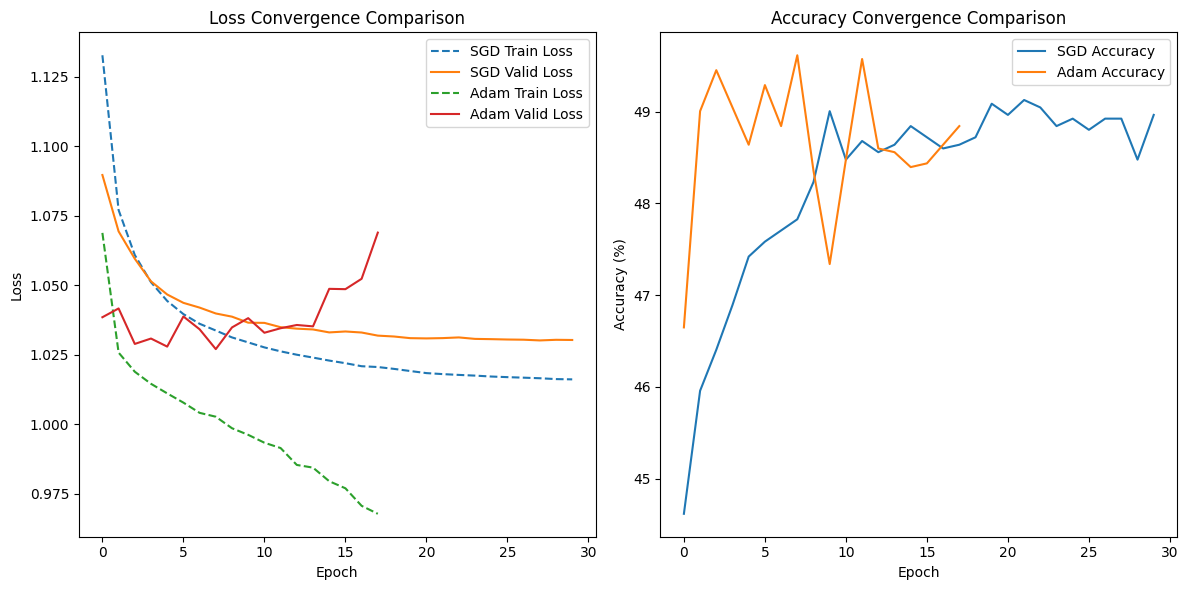

SGD Final Validation Loss: 1.0303, Final Validation Accuracy: 48.96%
Adam Final Validation Loss: 1.0690, Final Validation Accuracy: 48.84%


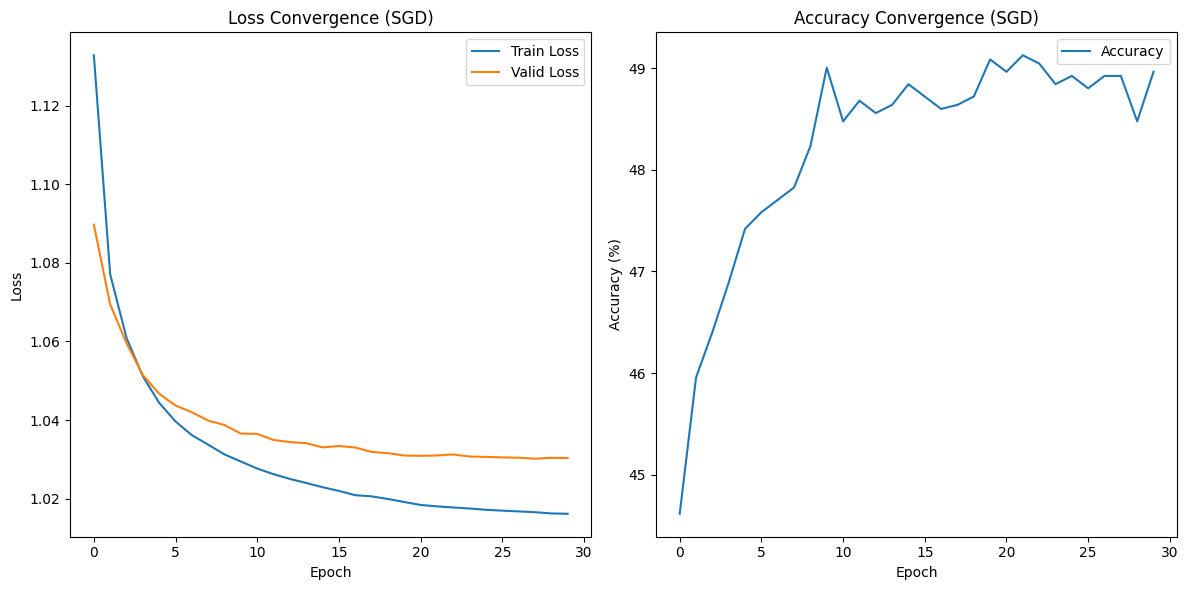

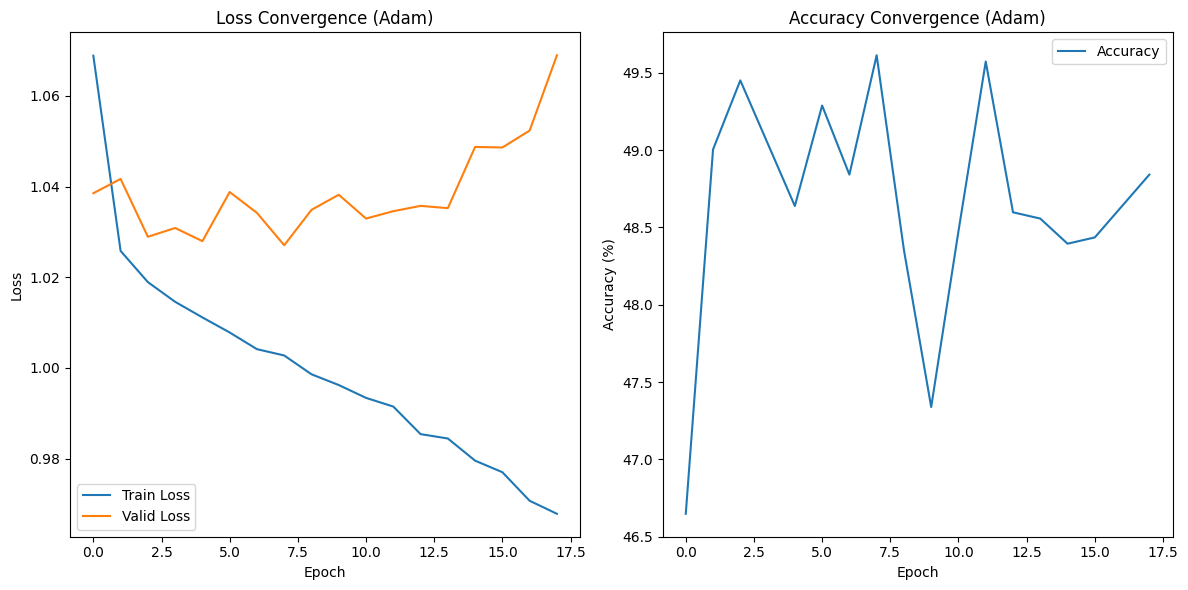

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

# Assuming X_train, y_train, X_valid, y_valid are already defined
X_train_tensor = torch.from_numpy(X_train.fillna(0).to_numpy()).float()
y_train_tensor = torch.from_numpy(y_train.to_numpy()).long()
X_valid_tensor = torch.from_numpy(X_valid.fillna(0).to_numpy()).float()
y_valid_tensor = torch.from_numpy(y_valid.to_numpy()).long()

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
valid_dataset = TensorDataset(X_valid_tensor, y_valid_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

def evaluate(model, criterion, loader):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            total_loss += criterion(outputs, labels).item()
            predicted = outputs.argmax(dim=1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    accuracy = 100 * correct / total
    return total_loss / len(loader), accuracy

class EarlyStopping:
    def __init__(self, patience, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.best_loss = float('inf')
        self.counter = 0

    def step(self, current_loss):
        if current_loss < self.best_loss:
            self.best_loss = current_loss
            self.counter = 0
            return True  # Indicates improvement
        else:
            self.counter += 1
            if self.counter >= self.patience:
                if self.verbose:
                    print("Early stopping triggered.")
                return False  # Stop training
        return True

def train_model(optimizer_name, lr=0.001, weight_decay=1e-5, hidden_size=32, num_epochs=30, early_stopping_patience=10):
    input_size = X_train_tensor.shape[1]
    num_classes = len(np.unique(y_train))

    model = NeuralNet(input_size, hidden_size, num_classes).to(device)
    criterion = nn.CrossEntropyLoss()

    if optimizer_name == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)
    elif optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    else:
        raise ValueError("Unknown optimizer")

    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

    early_stopping = EarlyStopping(patience=early_stopping_patience, verbose=True)

    train_losses, valid_losses, accuracies = [], [], []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        valid_loss, valid_accuracy = evaluate(model, criterion, valid_loader)
        valid_losses.append(valid_loss)
        accuracies.append(valid_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {valid_loss:.4f}, Accuracy: {valid_accuracy:.2f}%')

        if not early_stopping.step(valid_loss):
            break

        scheduler.step()

    return train_losses, valid_losses, accuracies, valid_loss, valid_accuracy

def plot_metrics(train_losses, valid_losses, accuracies, title_suffix=""):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(valid_losses, label='Valid Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Loss Convergence {title_suffix}')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(accuracies, label='Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title(f'Accuracy Convergence {title_suffix}')
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_comparison(sgd_results, adam_results):
    plt.figure(figsize=(12, 6))
    
    # Loss comparison
    plt.subplot(1, 2, 1)
    plt.plot(sgd_results[0], label='SGD Train Loss', linestyle='--')
    plt.plot(sgd_results[1], label='SGD Valid Loss')
    plt.plot(adam_results[0], label='Adam Train Loss', linestyle='--')
    plt.plot(adam_results[1], label='Adam Valid Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Convergence Comparison')
    plt.legend()
    
    # Accuracy comparison
    plt.subplot(1, 2, 2)
    plt.plot(sgd_results[2], label='SGD Accuracy')
    plt.plot(adam_results[2], label='Adam Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy Convergence Comparison')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Train models with different optimizers
sgd_results = train_model('SGD')
adam_results = train_model('Adam')

# Plot the comparison
plot_comparison(sgd_results, adam_results)




# Print the final performance of the models
print(f"SGD Final Validation Loss: {sgd_results[3]:.4f}, Final Validation Accuracy: {sgd_results[4]:.2f}%")
print(f"Adam Final Validation Loss: {adam_results[3]:.4f}, Final Validation Accuracy: {adam_results[4]:.2f}%")

# Plot the convergence pace
# plot_metrics(sgd_results[0], sgd_results[1], sgd_results[2], "(SGD)")
# plot_metrics(adam_results[0], adam_results[1], adam_results[2], "(Adam)")


Preprocessing (replace with real preprocessing steps later)

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim

X_train_tensor = torch.tensor(X_train.fillna(0).values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
X_valid_tensor = torch.tensor(X_valid.fillna(0).values, dtype=torch.float32)
y_valid_tensor = torch.tensor(y_valid.values, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
valid_dataset = TensorDataset(X_valid_tensor, y_valid_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)

class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# Define input size, hidden size, and number of classes
input_size = X_train.shape[1]
hidden_size = 32
num_classes = 2

model = NeuralNet(input_size, hidden_size, num_classes)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

# Training the model
num_epochs = 20
early_stopping_patience = 5
best_valid_loss = float('inf')
patience_counter = 0

for epoch in range(num_epochs):
    model.train()
    for i, (inputs, labels) in enumerate(train_loader):
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        l2_lambda = 0.05
        l2_reg = sum(param.pow(2.0).sum() for param in model.parameters())
        loss += l2_lambda * l2_reg
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # Validation
    model.eval()
    valid_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in valid_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    valid_loss /= len(valid_loader)
    accuracy = 100 * correct / total
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {valid_loss:.4f}, Accuracy: {accuracy:.2f}%')
    
    # Check for improvement
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')  # Save the best model
    else:
        patience_counter += 1
        if patience_counter >= early_stopping_patience:
            print("Early stopping triggered.")
            break
    
    scheduler.step()  # Adjust the learning rate


Epoch [1/20], Loss: 0.5734, Accuracy: 71.15%
Epoch [2/20], Loss: 0.5552, Accuracy: 72.02%
Epoch [3/20], Loss: 0.5559, Accuracy: 72.52%
Epoch [4/20], Loss: 0.5600, Accuracy: 71.71%
Epoch [5/20], Loss: 0.5922, Accuracy: 69.63%
Epoch [6/20], Loss: 0.5645, Accuracy: 72.07%
Epoch [7/20], Loss: 0.5539, Accuracy: 72.42%
Epoch [8/20], Loss: 0.5791, Accuracy: 71.25%
Epoch [9/20], Loss: 0.5571, Accuracy: 72.12%
Epoch [10/20], Loss: 0.5616, Accuracy: 72.47%
Epoch [11/20], Loss: 0.5607, Accuracy: 72.22%
Epoch [12/20], Loss: 0.5570, Accuracy: 71.86%
Early stopping triggered.


Accuracy

In [7]:
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

X_test_tensor = torch.tensor(X_test.fillna(0).values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
prediction_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

correct_predictions = 0
total_predictions = 0

model.eval()
with torch.no_grad():
    for inputs, labels in prediction_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

prediction_accuracy = 100 * correct_predictions / total_predictions
print(f'Accuracy of the model on the prediction set: {prediction_accuracy:.2f}%')

Accuracy of the model on the prediction set: 70.87%


Submission

In [8]:
test_home = pd.read_csv('./Test_Data/test_home_team_statistics_df.csv', index_col=0)
test_away = pd.read_csv('./Test_Data/test_away_team_statistics_df.csv', index_col=0)

test_home.columns = 'HOME_' + test_home.columns
test_away.columns = 'AWAY_' + test_away.columns
test_data = pd.concat([test_home, test_away], join='inner', axis=1)

test_data = test_data.reindex(columns=train_data.columns, fill_value=0)

X_test_tensor = torch.tensor(test_data.fillna(0).values, dtype=torch.float32)

model.load_state_dict(torch.load('best_model.pth'))

model.eval()

test_dataset = TensorDataset(X_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

predictions = []

# Make predictions on the test set
with torch.no_grad():
    for inputs in test_loader:
        outputs = model(inputs[0])
        _, predicted = torch.max(outputs.data, 1)
        predictions.extend(predicted.cpu().numpy())

predictions_df = pd.DataFrame(predictions, index=test_data.index, columns=['AWAY_WINS'])

submission = pd.DataFrame(index=test_data.index)
submission['HOME_WINS'] = (predictions_df['AWAY_WINS'] == 0).astype(int)
submission['DRAW'] = 0  # Assuming no draws in the predictions
submission['AWAY_WINS'] = predictions_df['AWAY_WINS']

submission.to_csv('./Test_Data/neural_network_submission.csv', index=True)